In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt

from utils import MaskedForward

In [2]:
# Configuración
batch_size = 64
threshold_accuracy = 0.70
sparsity_percentage = 0.3  # Porcentaje de pesos a conservar (más altos)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuración de reinicios organizados en diccionario
restart_checks = {
    # 7: {"accuracy": 0.50, "message": "VERY EARLY RESTART"},
    # 11: {"accuracy": 0.30, "message": "VERY EARLY RESTART"},
    # 33: {"accuracy": 0.55, "message": "EARLY RESTART"},
    # 70: {"accuracy": 0.50, "message": "RESTART"}
}

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

data_dir = '../../data/cifar10'

train_dataset = datasets.CIFAR10(root= data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  # Back to original dimensions for 32x32
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 4 * 4)  # Back to original dimensions for 32x32
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # Devuelve logits sin procesar

net = Net()
mask = Net()

net.to(device)
mask.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [5]:
# Congelar los parámetros de net (no se entrenarán)
for param in net.parameters():
    param.requires_grad = False

In [6]:
def restart_training():
    """Función para reinicializar net, mask y métricas"""
    global net, mask, optimizer, epoch, losses, accuracies, saved, restart_count
    
    restart_count += 1
    print("Reinicializando net y máscara, y reiniciando el entrenamiento...")
    
    # Reinicializar net (nueva inicialización aleatoria)
    net = Net()
    net.to(device)
    
    # Congelar los parámetros de net
    for param in net.parameters():
        param.requires_grad = False
    
    # Reinicializar la máscara
    mask = Net()
    mask.to(device)
    
    # Reinicializar el optimizador
    optimizer = optim.Adam(mask.parameters(), lr=0.001)
    
    # Reinicializar métricas
    epoch = 0
    losses = []
    accuracies = []
    saved = False

def check_restart_conditions():
    """Verifica todas las condiciones de reinicio usando el diccionario de configuración"""
    current_max_accuracy = max(accuracies) if accuracies else 0
    
    for check_epoch, config in restart_checks.items():
        min_acc = config["accuracy"] * 100
        restart_type = config["message"]
        
        # Para época mayor, verificar si es mayor o igual; para otras, verificar igualdad exacta
        should_check = epoch == check_epoch
        
        if should_check and current_max_accuracy < min_acc:
            print(f"\n!!! {restart_type} {restart_count + 1} !!!")
            print(f"No se alcanzó {min_acc}% de accuracy en época {check_epoch}.")
            restart_training()
            return True
    
    return False

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mask.parameters(), lr=0.001)
epoch = 0
saved = False
losses = []
accuracies = []
restart_count = 0

while True:
    # Verificar condiciones de reinicio
    if check_restart_conditions():
        continue
    
    masked_model = MaskedForward(net, mask, sparsity_percentage).to(device)
    masked_model.train()
    running_loss = 0.0

    epoch += 1
    print(f"\n===== Epoch {epoch} (Restart {restart_count}) =====")

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = masked_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    # Evaluación
    masked_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = masked_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    accuracies.append(accuracy)

    print(f"Epoch {epoch}: Avg Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    if accuracy >= threshold_accuracy * 100:
        print("Reached target accuracy. Stopping training.")
        if not saved:
            torch.save(net.state_dict(), "net_cnn_10.pth")
            torch.save(mask.state_dict(), "mask_cnn_10.pth")
            print(f"Models saved")
            saved = True
        else:
            print("Model already saved, skipping save.")
        break


===== Epoch 1 (Restart 0) =====
Epoch 1: Avg Loss = 1.8852, Test Accuracy = 36.18%

===== Epoch 2 (Restart 0) =====
Epoch 2: Avg Loss = 1.7497, Test Accuracy = 38.07%

===== Epoch 3 (Restart 0) =====
Epoch 3: Avg Loss = 1.7297, Test Accuracy = 37.87%

===== Epoch 4 (Restart 0) =====
Epoch 4: Avg Loss = 1.7202, Test Accuracy = 39.11%

===== Epoch 5 (Restart 0) =====
Epoch 5: Avg Loss = 1.7140, Test Accuracy = 38.94%

===== Epoch 6 (Restart 0) =====
Epoch 6: Avg Loss = 1.7123, Test Accuracy = 38.45%

===== Epoch 7 (Restart 0) =====
Epoch 7: Avg Loss = 1.7132, Test Accuracy = 39.25%

===== Epoch 8 (Restart 0) =====
Epoch 8: Avg Loss = 1.7118, Test Accuracy = 39.15%

===== Epoch 9 (Restart 0) =====
Epoch 9: Avg Loss = 1.7103, Test Accuracy = 39.37%

===== Epoch 10 (Restart 0) =====
Epoch 10: Avg Loss = 1.7086, Test Accuracy = 38.99%

===== Epoch 11 (Restart 0) =====
Epoch 11: Avg Loss = 1.7094, Test Accuracy = 39.38%

===== Epoch 12 (Restart 0) =====
Epoch 12: Avg Loss = 1.7093, Test Accu

KeyboardInterrupt: 

In [12]:
torch.save(net.state_dict(), "./models/net_cnn_30.pth")
torch.save(mask.state_dict(), "./models/mask_cnn_30.pth")

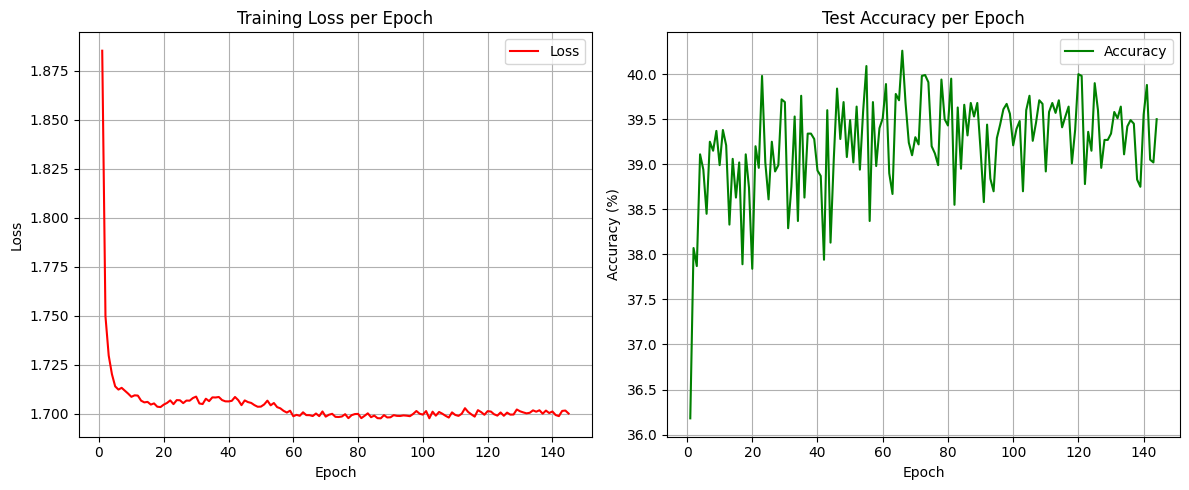

In [8]:
# Gráficos de pérdida y precisión en una sola figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de pérdida
ax1.plot(range(1, len(losses)+1), losses, label='Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss per Epoch')
ax1.legend()
ax1.grid(True)

# Gráfico de precisión
ax2.plot(range(1, len(accuracies)+1), accuracies, label='Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy per Epoch')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [9]:
print(losses)
print(len(losses))
print(accuracies)
print(len(accuracies))
print(epoch)

[1.8851531431498125, 1.7497104577091345, 1.729705436912644, 1.720160679286703, 1.7139745792159644, 1.7123310925710538, 1.7132178401703115, 1.711777025171558, 1.7102789313287077, 1.7086403029958914, 1.7094052063534633, 1.7092729752021067, 1.706689773922991, 1.7058012790387245, 1.7060514109213945, 1.704683889665872, 1.7052710730096567, 1.7035968785395708, 1.7034123716756815, 1.704668270809876, 1.7055058768948022, 1.7068111189186115, 1.704901672994999, 1.7069562108010587, 1.7068802496356428, 1.7054299108512567, 1.7067337440102912, 1.706679449514355, 1.7080303663792817, 1.7087539983222553, 1.7052503911125692, 1.7049521299274377, 1.7076692543066372, 1.7064363364978214, 1.708354294757404, 1.708303957948904, 1.7085550468596047, 1.7069918623055949, 1.7063412701382357, 1.7062995295085566, 1.7065913623861035, 1.708557420831812, 1.7069463338083624, 1.7043946173489857, 1.7068083580497586, 1.705949341854476, 1.705520874246612, 1.7044047487666234, 1.7035734008645158, 1.7036468787571353, 1.7047520633